# (실습) 선형회귀 모델링 방법론 실습



## 실습 개요

1) 실습 목적

회귀 모델링 방법론에 대한 이해도를 높이기 위해, 단순/다중 선형회귀모델이 어떤식으로 실제 데이터에
적용되는지 실습해봅니다.


2) 수강 목표
  - scikit learn 패키지를 활용해 단순 및 다중 선형회귀분석을 진행해보는 과정을 이해한다.
  - 선형회귀모델의 해석적 해법을 사용해 결정계수를 직접 계산해볼 수 있다.
  - 주어진 정형데이터에 대해 상관행렬을 계산하고 시각화해볼 수 있다.

### 목차

* 1. 실습 데이터셋 준비
  * 1-1. 데이터셋을 불러와 기본정보 확인
  * 1-2. 데이터셋의 전처리

* 2. 선형회귀모델의 학습
  * 2-1. 사이킷런 패키지를 활용한 선형회귀모델 학습
  * 2-2. 해석적 해법을 통해 파라미터를 계산

* 3. 상관계수 분석
  * 3-1. 상관행렬의 시각화
  * 3-2. 상관계수와 회귀계수(결정계수)

### 환경 설정

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### 실습 데이터셋
* 데이터셋: Diabetes Data
* 데이터셋 개요 :
첫번째 회귀 모델링 방법론 실습은 sklearn에서 제공하는 당뇨병 진행도 예측 데이터셋을 활용합니다.
이 데이터셋은 총 442개의 샘플을 포함하며, 각 샘플은 다음과 같은 10개의 인풋 피쳐로 구성됩니다.
  - age: 나이
  - sex: 성별
  - bmi: Body mass index
  - bp: Average blood pressure
  - 혈청에 대한 6가지 지표들(S1, S2, S3, S4, S5, S6)

  데이터셋의 target은 다른 피쳐들의 측정 시점으로부터 1년 후 당뇨병이 진행된 정도를 나타내는 수치로 주어지는데, 이 실습에서는 선형회귀모델을 학습해 target값을 예측해보도록 합니다.
* 데이터셋 저작권 : BSD License



## 1. 실습 데이터셋 준비
```
💡 목차 개요 : 실습에 사용할 Diabetes 데이터셋을 불러와 살펴봅니다.
```

### 1-1 데이터셋을 불러와 기본정보 확인
> Scikit learn에서 제공하는 `load_diabetes` 함수를 사용해 실습에 사용할 당뇨병 데이터셋을
불러온 뒤, 기본적인 정보를 확인해봅니다.


#### 📝 설명 : 데이터의 "설명" 정보

사이킷런에서 제공하는 데이터셋은 총 8개 항목을 포함하는 dictionary 형태로 반환되는데,
본 실습에서는 이 중 다음의 세개 항목만을 활용하도록 하겠습니다.
- **data:** 각 샘플별 인풋 피쳐들을 포함
- **target:** 각 샘플별 목표값을 포함
- **DESCR:** 데이터셋에 대한 간략한 설명

이중 `DESCR`항목은 데이터셋에 대한 유용한 정보를 포함하므로 한번 출력해 확인해봅니다.

#### 👨‍💻 코드 : Diabetes 데이터셋을 로드하고, 설명 섹션 확인

In [ ]:
# 당뇨병 데이터셋을 로드
diabetes = load_diabetes(scaled=False)

# 데이터셋의 "설명"(description)섹션 확인
print(diabetes["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

### 1-2. 데이터셋의 전처리
> 모델이 데이터셋을 잘 학습하도록 전처리를 적용합니다.

#### 📝 설명 : 데이터셋의 전처리

이 데이터셋은 기본적으로 각 column마다 샘플을 **전부 더했을 때** 표준편차가 1이 되도록 정규화를
해주는 `scaled` 옵션이 설정되어있지만, 이는 일반적으로 사용되는 방식과 다르므로 위에서
`scaled=False`로 설정해 데이터를 스케일 조정 없이 원본 데이터를 받아왔습니다.
여기에서 평균, 표준편차가 각각 0, 1이 되도록 만드는 표준화(Standardization) 방식의 전처리를 별도로 진행해주겠습니다.


#### 👨‍💻 코드 : 데이터셋 전처리 적용
- 인풋 데이터를 pandas의 `DataFrame` 오브젝트로 변환
- 인풋 데이터에 표준화 전처리 적용
- 목표값에도 같은 방식으로 전처리 적용

In [ ]:
# 분석에 필요한 정보만 가져온 후, pandas 데이터프레임으로 변환
data = diabetes["data"]
data = pd.DataFrame(data, columns=diabetes["feature_names"])

# Standardization 방식의 전처리 적용을 위해 feature별 평균값, 표준편차를 계산
fts_mean = data.mean(axis=0)
fts_std = data.std(axis=0)

# 평균이 0, 표준편차가 1이 되도록 표준화
data = (data - fts_mean) / fts_std

# 결과 확인. 모든 변수가 평균 0, 표준편차 1로 조정된 것을 확인합니다.
data.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,442.000000,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,0.000000,2.893613e-16,-4.694083e-15,-1.000708e-15,-2.893613e-16,8.238759e-16,-1.245861e-16,-1.527185e-16,1.945151e-15,2.531911e-16
std,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.251738,-9.374744e-01,-1.895781e+00,-2.360375e+00,-2.662394e+00,-2.427874e+00,-2.148448e+00,-1.604285e+00,-2.648040e+00,-2.893112e+00
25%,-0.783285,-9.374744e-01,-7.188104e-01,-7.697777e-01,-7.192046e-01,-6.375263e-01,-7.374604e-01,-8.293610e-01,-6.981574e-01,-6.967595e-01
50%,0.113044,-9.374744e-01,-1.529591e-01,-1.190789e-01,-9.073818e-02,-8.020037e-02,-1.382738e-01,-5.443750e-02,-4.089059e-02,-2.263165e-02
75%,0.799594,1.064282e+00,6.562083e-01,7.485196e-01,5.955183e-01,6.267323e-01,6.155415e-01,7.204860e-01,6.810788e-01,5.862581e-01
max,2.325260,1.064282e+00,3.581660e+00,2.772916e+00,3.232188e+00,4.174548e+00,3.804760e+00,3.889923e+00,2.805543e+00,2.847848e+00


In [ ]:
target = diabetes["target"]
# target 변수의 모양 확인
print(target.shape)

# 처음 10개 값들만 뽑아서 확인
print("Original target values: ", target[:10])

# target의 평균값, 표준편차를 계산
tgt_mean = target.mean()
tgt_std = target.std()

# 표준화 적용
target = (target - tgt_mean) / tgt_std

# 결과 확인
print("Scaled target values: ", target[:10])
print(f"Mean: {target.mean()}, Std: {target.std()}")

(442,)
Original target values:  [151.  75. 141. 206. 135.  97. 138.  63. 110. 310.]
Scaled target values:  [-0.01471948 -1.00165882 -0.14457991  0.69951294 -0.22249618 -0.71596585
 -0.18353805 -1.15749134 -0.54714728  2.05006151]
Mean: -1.687940888117885e-16, Std: 1.0




### 1-3 데이터셋의 분할
> 모델의 학습을 진행하기 전에 데이터셋을 학습용 / 평가용으로 분할합니다.



#### 👨‍💻 코드 : 데이터셋 분할

- Scikit learn에서 제공하는 `train_test_split` 함수를 활용
- 전체 데이터셋을 7:3비율로 분할해 학습용, 평가용으로 나눔.

In [ ]:
# 재현성을 위해 random state를 지정
random_state = 1234

# train과 test를 7:3의 비율로 분할
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.3, random_state=random_state)

# 분할이 잘 이뤄졌는지 확인
print(f"train data: {train_data.shape}")
print(f"train target: {train_target.shape}")
print(f"test data: {test_data.shape}")
print(f"test target: {test_target.shape}")

train data: (309, 10)
train target: (309,)
test data: (133, 10)
test target: (133,)


## 2. 선형회귀 모델의 학습
```
💡 목차 개요 : 전처리가 완료된 데이터를 이용해 선형회귀 모델을 학습하는 방법을 실습합니다.
```



### 2-1 사이킷런을 활용한 선형회귀 모델 학습
> Scikit learn 패키지에 포함된 `LinearRegression`클래스를 활용해 선형회귀 모델을 학습하고,
그 결과를 확인해봅니다.


#### 👨‍💻 코드 : 사이킷런을 활용한 다중선형회귀모델 학습
- scikit learn패키지에 포함된 `LinearRegression`모델을 불러와 초기화
- 학습용 데이터셋을 이용해 학습
- 학습 결과로 나온 회귀식을 확인

In [ ]:
# (다중) 선형회귀모델 초기화
multi_regressor = LinearRegression()

# 학습용 데이터셋을 활용해 학습 진행
multi_regressor.fit(train_data, train_target)

# 회귀식의 intercept(Ax+b에서 b부분) 확인
# 데이터을 평균이 0이 되도록 전처리했으므로 0에 가까운 값이 나온다.
print("intercept: ", multi_regressor.intercept_)
# 학습된 회귀식 확인
print("coefficients: ", multi_regressor.coef_)

intercept:  0.0032051491826457033
coefficients:  [-0.01527643 -0.17349446  0.32617627  0.19694471 -0.43681934  0.25497509
  0.04320066  0.10606027  0.46579857  0.04794608]



#### 👨‍💻 코드 : 다중선형회귀모델 학습의 결과 확인
- 학습용, 평가용 데이터셋에서 모델의 예측값 계산
- 계산된 예측값을 목표값과 비교해 MSE손실함수값을 확인

In [ ]:
# 학습, 평가 데이터셋에서 회귀식의 예측값 계산
multi_train_pred = multi_regressor.predict(train_data)
multi_test_pred = multi_regressor.predict(test_data)

# 위의 예측값을 목표값과 비교해 MSE 손실함수의 값 계산
multi_train_mse = mean_squared_error(multi_train_pred, train_target)
multi_test_mse = mean_squared_error(multi_test_pred, test_target)
print(f"Train MSE: {multi_train_mse:.5f}")
print(f"Test MSE: {multi_test_mse:.5f}")

Train MSE: 0.48483
Test MSE: 0.48035


#### 📝 설명 : 결과의 시각화

모델의 예측 결과가 얼마나 목표값과 비슷하게 나왔는지 확인해보기 위해 목표값을 x축, 예측값을 y축으로
하는 산점도를 도식화해봅니다. 각각의 점들은 평가용 데이터셋의 샘플 한개에 대한 목표값과 예측값을
나타내므로, 이 점이 주황색으로 표시된 $x=y$ 직선에 가까울수록 잘 예측된것입니다.

시각화 결과 완벽하지는 않지만 샘플들이 $x=y$ 주변에 몰려있어 어느정도 모델의 예측이 성공적이었다는 것을 알 수 있습니다.

(그래프는 비슷하게 생겼지만, 이 그래프는 파란색 점들에 대해 단순선형회귀를 진행한것이 아닙니다)

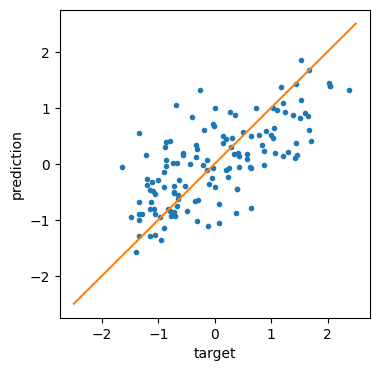

In [ ]:
plt.figure(figsize=(4, 4))

plt.xlabel("target")
plt.ylabel("prediction")
# 테스트셋의 목표값(x축)과 모델의 예측값(y축)을 산점도로 도식화
y_pred = multi_regressor.predict(test_data)
plt.plot(test_target, y_pred, '.')

# y = x 직선을 플롯. 이 직선에 가까운 점일수록 정확한 예측이다.
x = np.linspace(-2.5, 2.5, 10)
y = x
plt.plot(x, y)

plt.show()



### 2-2 해석적 해법을 통한 파라미터를 계산
> 최소제곱 선형회귀문제의 해석적 해법을 이용해, numpy만으로 파라미터를 직접 계산해봅니다.


#### 📝 설명 : 선형회귀의 해석적 해법

위에서는 사이킷런 패키지에 포함된 선형회귀모델의 클래스를 호출해 학습해보았지만, 최소제곱 손실함수를 사용하는 선형회귀모델의 경우, $\theta=(X^TX)^{-1}X^Ty$ 이라는 해석적 해법(Analytical Solution)이 알려져 있기 때문에, numpy만을 사용해서도 파라미터를 어렵지않게
구해볼 수 있습니다.

#### 👨‍💻 코드 : 해석적 해법을 사용한 파라미터 계산

- 위의 공식을 Ax=b 형태로 변환 후 numpy를 이용해 solve
- 결과를 위에서 계산한 값과 비교



In [ ]:
# 위의 식을 일반적인 linear equation인 Ax=b 형태로 변형
A = train_data.T @ train_data
b = train_data.T @ train_target

# numpy를 활용해 linear equation 풀기
coef = np.linalg.solve(A, b)

# 학습된 parameter를 이용해 예측값을 내놓는 함수를 정의
def predict(data, coef):
    return data @ coef

# 학습, 평가 데이터셋에서 회귀식의 예측값 계산
train_pred = predict(train_data, coef)
test_pred = predict(test_data, coef)

# 위의 예측값을 목표값과 비교해 MSE 손실함수의 값 계산
train_mse = mean_squared_error(train_pred, train_target)
test_mse = mean_squared_error(test_pred, test_target)

print(f"Multi Regression Train MSE is {train_mse:.5f}")
print(f"Multi Regression Test MSE is {test_mse:.5f}")


Multi Regression Train MSE is 0.48484
Multi Regression Test MSE is 0.48031


In [ ]:
# scikit-learn 패키지를 활용한 학습 결과
print(multi_regressor.coef_)
# 해석적 해법을 이용해 직접 계산한 학습 결과
print(coef)

[-0.01527643 -0.17349446  0.32617627  0.19694471 -0.43681934  0.25497509
  0.04320066  0.10606027  0.46579857  0.04794608]
[-0.01525589 -0.17358803  0.3260196   0.19691551 -0.43690798  0.2551445
  0.04317958  0.10602557  0.46595566  0.04789441]


#### 📝 설명 : 결과 해석

해석적 해법을 통해 구한 파라미터값이 위에서 scikit learn 패키지를 사용해 구한것과 정확히
일치하는것을 확인할 수 있습니다.


## 3. 단순선형회귀와 상관관계 분석
```
데이터셋의 탐색 단계에서 자주 활용되는 상관행렬의 시각화를 진행해봅니다.
```

### 3-1. 상관계수와 상관행렬

상관계수는 두 변수 x, y 사이의 상관관계의 강도를 나타내는 수치로, 두 변수 사이의 단순선형회귀분석이
얼마나 효과적일지를 나타내는 것으로도 해석할 수 있습니다.

- 항상 -1 에서 1 범위의 값으로 나타나며,
- 절대값의 크기는 직선관계에 가까운 정도를,
- 부호는 직선관계의 방향을 나타냅니다.

![상관관계 예시](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Correlation_examples2.svg/2880px-Correlation_examples2.svg.png)

    출처 :  https://ko.wikipedia.org/wiki/%EC%83%81%EA%B4%80_%EB%B6%84%EC%84%9D#/media/%ED%8C%8C%EC%9D%BC:Correlation_examples2.svg



#### 👨‍💻 코드: 상관행렬의 시각화
- pandas DataFrame오브젝트의 상관행렬을 구하기
- 상관행렬의 중복되는 부분을 제거하고 나머지 부분을 시각화

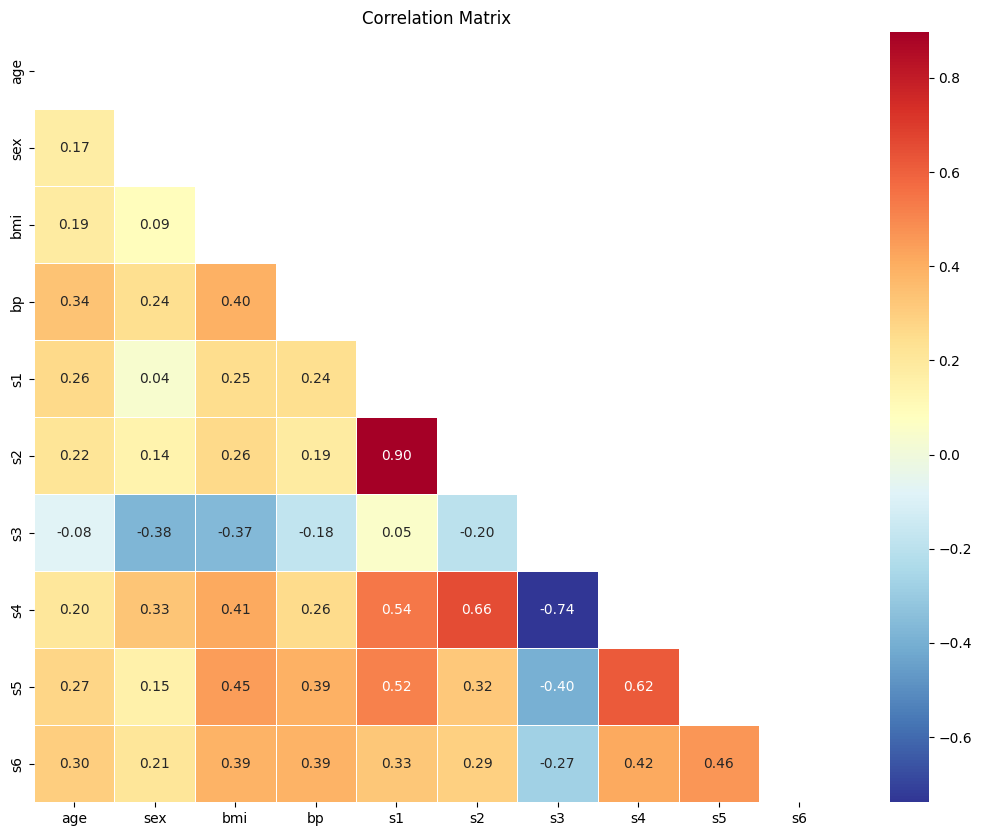

In [ ]:
# 데이터의 상관계수 행렬을 생성
corr = data.corr(numeric_only=True)

# figure에서 생략될 부분을 지정하는 mask 행렬을 생성
mask = np.ones_like(corr, dtype=bool)
mask = np.triu(mask)

# 시각화될 그림의 크기를 지정
# 히트맵 형태로 상관행렬 시각화하기
plt.figure(figsize=(13,10))
sns.heatmap(data=corr, annot=True, fmt='.2f', mask=mask, linewidths=.5, cmap='RdYlBu_r')
plt.title('Correlation Matrix')
plt.show()



### 3-2. 상관계수와 회귀계수(결정계수)
> 상관계수와 회귀분석의 관계를 이해하기 위해, 상관행렬에 나타난 여러 변수들 중 한 쌍을 골라 단순선형 회귀분석을 진행해봅니다.


#### 👨‍💻 코드 : 단순선형회귀분석
- 상관행렬에서 두 변수를 선택해 단순선형회귀분석 모델을 학습
- 회귀계수와 상관계수의 관계


In [ ]:
# 단순선형회귀분석을 진행할 두 변수를 선정
x_feature = "s3"
y_feature = "s2"

# 모델 초기화 및 학습
simple_regressor = LinearRegression()
simple_regressor.fit(data[[x_feature]], data[[y_feature]])

# 결과 회귀계수 확인
coef = simple_regressor.coef_
print(coef)

[[-0.19645512]]


#### 📝 설명 : 상관계수와 회귀계수

위에서 단순선형회귀분석을 진행한 결과, 회귀계수의 값이 두 변수의 상관계수와 매우 비슷한 값이 나왔는데,
이는 우연히 그렇게 된 것이 아닙니다. 위의 전처리 파트에서 진행한것과 같이 각 변수들에 대해 평균이 0,
표준편차가 1이 되도록 표준화 전처리를 진행해준 경우 항상 이렇게 단순선형회귀의 계수는 상관계수와 같은
값이 나오게 됩니다.


#### 📚 자료

*  [결정계수와 상관계수의 관계에 대한 증명](https://statproofbook.github.io/P/slr-rsq.html) :
어떻게 위와 같은 결과가 나오는지 증명 과정이 궁금하시다면, 이 링크의 글을 참조하세요.



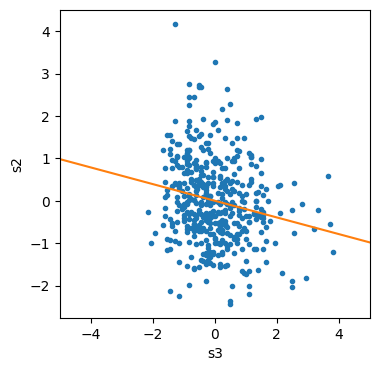

In [ ]:
# 원본 데이터변수를 산점도로 시각화
plt.figure(figsize=(4, 4))
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.plot(data[[x_feature]], data[[y_feature]], ".")

# 전체 데이터를 도식화 할 x값 범위를 설정
x_min, x_max = -5, 5
plt.xlim(x_min, x_max)

# 회귀 직선식을 플롯
x = np.linspace(x_min, x_max, 10)
y = coef.item() * x  # item() 함수는 원소가 1개인 array를 단순 scalar로 변환할 때 사용
plt.plot(x, y)

plt.show()

## 콘텐츠 라이선스

저작권 : <font color='blue'> <b> ©2023 by Upstage X fastcampus Co., Ltd. All rights reserved.</font></b>

<font color='red'><b>WARNING</font> : 본 교육 콘텐츠의 지식재산권은 업스테이지 및 패스트캠퍼스에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다. </b>